#  Deep Learning for Super Resolution on DestinE Climate Data

Destine Login

In [ ]:
%%capture cap
%run auth/cacheb-authentication.py

In [ ]:
output_1 = cap.stdout.split('}\n')
token = output_1[-1][0:-1]

from pathlib import Path
with open(Path.home() / ".netrc", "a") as fp:
    fp.write(token)

### Import dependencies

In [1]:
import warnings
import torch
import lightning as L
import numpy as np
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from lightning.pytorch import seed_everything
from lightning.pytorch.callbacks import ModelCheckpoint
from utils.general import (get_bbox_from_config,
                           load_config, compute_mean_std,
                           create_gif_from_images,
                           save_best_model_as_pt,
                           save_config_to_log_dir)
from data.loaders import load_data
from data.datasets import CreateDataset
import models.models as models
from trainer import TrainerSr
# Ignore warnings and set precision
warnings.filterwarnings("ignore")
torch.set_float32_matmul_precision('high')

Seed set to 42


### 1. Load Configuration

In [2]:
# Load configuration and set seed
config = load_config()
seed_everything(config["training"]["seed"], workers=True)

Seed set to 42


42

In [46]:
import xarray as xr

lr_data = xr.open_dataset(
    config["dataset"]["lr_zarr_url"],
    engine="zarr", storage_options={"client_kwargs": {"trust_env": "true"}},
    chunks={})

lr_data = lr_data.astype("float32")
latitude_range = tuple(config["dataset"]["latitude_range"])
longitude_range = tuple(config["dataset"]["longitude_range"])
lr = lr_data.sel(latitude=slice(latitude_range[0],latitude_range[1]),
                    longitude=slice(longitude_range[0],longitude_range[1]))

start_date = config["dataset"]["start_date"]
end_date = config["dataset"]["end_date"]
print(start_date)
print(end_date)

lr = lr.sel(time=slice(start_date, end_date))
size_in_mb = lr.nbytes / (1024 * 1024)
print(f"Dataset size: {size_in_mb:.2f} MB")
lr

2020-01-01
2024-01-01
Dataset size: 2467.39 MB


<xarray.Dataset> Size: 3GB
Dimensions:    (time: 35088, latitude: 32, longitude: 32)
Coordinates:
  * latitude   (latitude) float64 256B 47.03 47.38 47.73 ... 57.24 57.59 57.95
  * longitude  (longitude) float64 256B 5.273 5.625 5.977 ... 15.47 15.82 16.17
    step       timedelta64[ns] 8B ...
    surface    float64 8B ...
  * time       (time) datetime64[ns] 281kB 2020-01-01 ... 2024-01-01T23:00:00
Data variables: (12/18)
    blh        (time, latitude, longitude) float32 144MB dask.array<chunksize=(576, 32, 32), meta=np.ndarray>
    chnk       (time, latitude, longitude) float32 144MB dask.array<chunksize=(576, 32, 32), meta=np.ndarray>
    d2m        (time, latitude, longitude) float32 144MB dask.array<chunksize=(576, 32, 32), meta=np.ndarray>
    hcc        (time, latitude, longitude) float32 144MB dask.array<chunksize=(576, 32, 32), meta=np.ndarray>
    lcc        (time, latitude, longitude) float32 144MB dask.array<chunksize=(576, 32, 32), meta=np.ndarray>
    mcc        (time, latitude, longitude) float32 144MB dask.array<chunksize=(576, 32, 32), meta=np.ndarray>
    ...         ...
    tciw       (time, latitude, longitude) float32 144MB dask.array<chunksize=(576, 32, 32), meta=np.ndarray>
    tclw       (time, latitude, longitude) float32 144MB dask.array<chunksize=(576, 32, 32), meta=np.ndarray>
    tcwv       (time, latitude, longitude) float32 144MB dask.array<chunksize=(576, 32, 32), meta=np.ndarray>
    tprate     (time, latitude, longitude) float32 144MB dask.array<chunksize=(576, 32, 32), meta=np.ndarray>
    u10        (time, latitude, longitude) float32 144MB dask.array<chunksize=(576, 32, 32), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 144MB dask.array<chunksize=(576, 32, 32), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            2
    GRIB_subCentre:          1003
    history:                 2024-03-27T16:00 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

In [47]:
# Define the local save path
lr_save_path = "ScenarioMIP-SSP3-7.0-IFS-NEMO-0001-standard-sfc-v0.zarr"
# Save the dataset
lr.to_zarr(lr_save_path, mode="w")
lr_loaded = xr.open_dataset(lr_save_path, engine="zarr")
lr_loaded

<xarray.Dataset> Size: 3GB
Dimensions:    (time: 35088, latitude: 32, longitude: 32)
Coordinates:
  * latitude   (latitude) float64 256B 47.03 47.38 47.73 ... 57.24 57.59 57.95
  * longitude  (longitude) float64 256B 5.273 5.625 5.977 ... 15.47 15.82 16.17
    step       timedelta64[ns] 8B ...
    surface    float64 8B ...
  * time       (time) datetime64[ns] 281kB 2020-01-01 ... 2024-01-01T23:00:00
Data variables: (12/18)
    blh        (time, latitude, longitude) float32 144MB ...
    chnk       (time, latitude, longitude) float32 144MB ...
    d2m        (time, latitude, longitude) float32 144MB ...
    hcc        (time, latitude, longitude) float32 144MB ...
    lcc        (time, latitude, longitude) float32 144MB ...
    mcc        (time, latitude, longitude) float32 144MB ...
    ...         ...
    tciw       (time, latitude, longitude) float32 144MB ...
    tclw       (time, latitude, longitude) float32 144MB ...
    tcwv       (time, latitude, longitude) float32 144MB ...
    tprate     (time, latitude, longitude) float32 144MB ...
    u10        (time, latitude, longitude) float32 144MB ...
    v10        (time, latitude, longitude) float32 144MB ...
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            2
    GRIB_subCentre:          1003
    history:                 2024-03-27T16:00 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

In [48]:
lr_loaded

<xarray.Dataset> Size: 3GB
Dimensions:    (time: 35088, latitude: 32, longitude: 32)
Coordinates:
  * latitude   (latitude) float64 256B 47.03 47.38 47.73 ... 57.24 57.59 57.95
  * longitude  (longitude) float64 256B 5.273 5.625 5.977 ... 15.47 15.82 16.17
    step       timedelta64[ns] 8B ...
    surface    float64 8B ...
  * time       (time) datetime64[ns] 281kB 2020-01-01 ... 2024-01-01T23:00:00
Data variables: (12/18)
    blh        (time, latitude, longitude) float32 144MB ...
    chnk       (time, latitude, longitude) float32 144MB ...
    d2m        (time, latitude, longitude) float32 144MB ...
    hcc        (time, latitude, longitude) float32 144MB ...
    lcc        (time, latitude, longitude) float32 144MB ...
    mcc        (time, latitude, longitude) float32 144MB ...
    ...         ...
    tciw       (time, latitude, longitude) float32 144MB ...
    tclw       (time, latitude, longitude) float32 144MB ...
    tcwv       (time, latitude, longitude) float32 144MB ...
    tprate     (time, latitude, longitude) float32 144MB ...
    u10        (time, latitude, longitude) float32 144MB ...
    v10        (time, latitude, longitude) float32 144MB ...
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            2
    GRIB_subCentre:          1003
    history:                 2024-03-27T16:00 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

In [49]:
hr_data = xr.open_dataset(
    config["dataset"]["hr_zarr_url"],
    engine="zarr", storage_options={"client_kwargs": {"trust_env": "true"}},
    chunks={})

hr_data = hr_data.astype("float32")
latitude_range = tuple(config["dataset"]["latitude_range"])
longitude_range = tuple(config["dataset"]["longitude_range"])
hr = hr_data.sel(latitude=slice(latitude_range[0],latitude_range[1]),
                    longitude=slice(longitude_range[0],longitude_range[1]))

start_date = config["dataset"]["start_date"]
end_date = config["dataset"]["end_date"]
print(start_date)
print(end_date)

hr = hr.sel(time=slice(start_date, end_date))

size_in_mb = hr.nbytes / (1024 * 1024)
print(f"Dataset size: {size_in_mb:.2f} MB")

2020-01-01
2024-01-01
Dataset size: 298248.27 MB


In [50]:
hr = hr[['t2m','d2m']]
hr

<xarray.Dataset> Size: 18GB
Dimensions:           (time: 35088, latitude: 256, longitude: 256)
Coordinates:
    entireAtmosphere  float64 8B ...
  * latitude          (latitude) float64 2kB 47.01 47.05 47.1 ... 58.18 58.22
  * longitude         (longitude) float64 2kB 5.01 5.054 5.098 ... 16.17 16.22
    step              timedelta64[ns] 8B ...
    surface           float64 8B ...
  * time              (time) datetime64[ns] 281kB 2020-01-01 ... 2024-01-01T2...
Data variables:
    t2m               (time, latitude, longitude) float32 9GB dask.array<chunksize=(48, 256, 256), meta=np.ndarray>
    d2m               (time, latitude, longitude) float32 9GB dask.array<chunksize=(48, 256, 256), meta=np.ndarray>
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            2
    GRIB_subCentre:          1003
    history:                 2024-11-14T08:10 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

In [51]:
size_in_mb = hr.nbytes / (1024 * 1024)
print(f"Dataset size: {size_in_mb:.2f} MB")

Dataset size: 17544.27 MB


In [52]:
hr_save_path = "ScenarioMIP-SSP3-7.0-IFS-NEMO-0001-high-sfc-v0.zarr"
# Save the dataset
hr.to_zarr(hr_save_path, mode="w")

In [53]:
hr_loaded = xr.open_dataset(hr_save_path, engine="zarr")
hr_loaded

<xarray.Dataset> Size: 18GB
Dimensions:           (time: 35088, latitude: 256, longitude: 256)
Coordinates:
    entireAtmosphere  float64 8B ...
  * latitude          (latitude) float64 2kB 47.01 47.05 47.1 ... 58.18 58.22
  * longitude         (longitude) float64 2kB 5.01 5.054 5.098 ... 16.17 16.22
    step              timedelta64[ns] 8B ...
    surface           float64 8B ...
  * time              (time) datetime64[ns] 281kB 2020-01-01 ... 2024-01-01T2...
Data variables:
    d2m               (time, latitude, longitude) float32 9GB ...
    t2m               (time, latitude, longitude) float32 9GB ...
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            2
    GRIB_subCentre:          1003
    history:                 2024-11-14T08:10 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

In [54]:
import xarray as xr


def load_data(config):
    """
    Load low-resolution (LR) and high-resolution (HR) data based on the configuration.

    Args:
        config (dict): Configuration dictionary containing dataset paths and other settings.

    Returns:
        lr (xarray.DataArray): Low-resolution dataset.
        hr (xarray.DataArray): High-resolution dataset.
    """

    lr_data = xr.open_dataset(
        config["dataset"]["lr_zarr_url"],
        engine="zarr",
    storage_options={"client_kwargs": {"trust_env": "true"}},
        chunks={},
    )

    lr_data = lr_data[config["dataset"]["data_variable"]]
    lr_data = lr_data.astype("float32")
    latitude_range = tuple(config["dataset"]["latitude_range"])
    longitude_range = tuple(config["dataset"]["longitude_range"])

    lr = lr_data.sel(latitude=slice(latitude_range[0],latitude_range[1]),
                    longitude=slice(longitude_range[0],longitude_range[1]))
    lr = lr.sel(time=config["dataset"]["time_range"]).load()
    # Load high-resolution data
    hr_data = xr.open_dataset(
        config["dataset"]["hr_zarr_url"],
        engine="zarr",
        storage_options={"client_kwargs": {"trust_env": "true"}},
        chunks={},
    )
    hr_data = hr_data[config["dataset"]["data_target"]]
    hr_data = hr_data.astype("float32")
    hr = hr_data.sel(latitude=slice(latitude_range[0],latitude_range[1]),
                    longitude=slice(longitude_range[0],longitude_range[1]))
    hr = hr.sel(time=config["dataset"]["time_range"])

    hr.attrs["units"] = config["dataset"]["unit"]
    lr.attrs["units"] = config["dataset"]["unit"]
    if config["training"]["streaming"]:
        return lr, hr
    else:

        return lr.load(), hr.load()

### 2. Load Data and Compute Statistics


In [55]:
# Load bounding box and data
bbox = get_bbox_from_config(config=config)
lr, hr = load_data(config=config)

In [56]:
hr = hr_loaded[config['dataset']['data_target']]
lr = lr_loaded[config['dataset']['data_variable']]

In [57]:
size_in_mb = lr.nbytes / (1024 * 1024)
print(f"Dataset size: {size_in_mb:.2f} MB")

Dataset size: 2467.39 MB


In [58]:
size_in_mb = hr.nbytes / (1024 * 1024)
print(f"Dataset size: {size_in_mb:.2f} MB")

Dataset size: 8772.27 MB


In [59]:
hr

<xarray.Dataset> Size: 9GB
Dimensions:           (time: 35088, latitude: 256, longitude: 256)
Coordinates:
    entireAtmosphere  float64 8B ...
  * latitude          (latitude) float64 2kB 47.01 47.05 47.1 ... 58.18 58.22
  * longitude         (longitude) float64 2kB 5.01 5.054 5.098 ... 16.17 16.22
    step              timedelta64[ns] 8B ...
    surface           float64 8B ...
  * time              (time) datetime64[ns] 281kB 2020-01-01 ... 2024-01-01T2...
Data variables:
    t2m               (time, latitude, longitude) float32 9GB ...
Attributes:
    Conventions:             CF-1.7
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_edition:            2
    GRIB_subCentre:          1003
    history:                 2024-11-14T08:10 GRIB to CDM+CF via cfgrib-0.9.1...
    institution:             European Centre for Medium-Range Weather Forecasts

In [60]:

# # Compute mean and standard deviation for normalization
# hr_mean, hr_std = compute_mean_std(hr)
# lr_mean, lr_std = compute_mean_std(lr)

# # Update config with computed mean and std
# config["dataset"]["hr_mean"] = hr_mean
# config["dataset"]["hr_std"] = hr_std
# config["dataset"]["lr_mean"] = lr_mean
# config["dataset"]["lr_std"] = lr_std

# # Display computed statistics
# print(f"HR mean: {hr_mean}, HR std: {hr_std}")
# print(f"LR mean: {lr_mean}, LR std: {lr_std}")

### 3. Split Data into Train, Validation, and Test Sets

In [61]:
# Split indices for train, validation, and test sets
batch_size = config['training']['batch_size']
time_indices = np.arange(len(hr.time.values))

train_indices, remaining_indices = train_test_split(
    time_indices, train_size=0.70, shuffle=True, random_state=config["training"]["seed"]
)
val_indices, test_indices = train_test_split(
    remaining_indices, test_size=config["validation"]["val_split_ratio"], shuffle=False, random_state=config["training"]["seed"]
)

# Split datasets into train, validation, and test sets
train_lr, train_hr = lr.isel(time=train_indices), hr.isel(time=train_indices)
val_lr, val_hr = lr.isel(time=val_indices), hr.isel(time=val_indices)
test_lr, test_hr = lr.isel(time=test_indices), hr.isel(time=test_indices)

# Print dataset sizes
print(f"Train samples: {len(train_hr.time.values)}")
print(f"Validation samples: {len(val_hr.time.values)}")
print(f"Test samples: {len(test_hr.time.values)}")

Train samples: 24561
Validation samples: 7368
Test samples: 3159


In [62]:
## Feature-wise Normalization
variables = list(lr.data_vars)

def normalize_xarray(dataset, variables):
    """
    Normalize an xarray dataset feature-wise for each time index.

    Args:
        dataset (xr.Dataset): Input xarray dataset
        variables (list): List of variable names to normalize

    Returns:
        xr.Dataset: Normalized dataset
    """
    normalized_data = {}

    for v in variables:
        # Compute mean & std for each time step independently
        mean = dataset[v].mean(dim=["latitude", "longitude"])
        std = dataset[v].std(dim=["latitude", "longitude"])

        # Normalize feature-wise per time step
        normalized_data[v] = (dataset[v] - mean) / std

    # Return as a new xarray dataset
    return xr.Dataset(normalized_data, coords=dataset.coords)

# Example usage
normalized_lr = normalize_xarray(lr, variables)

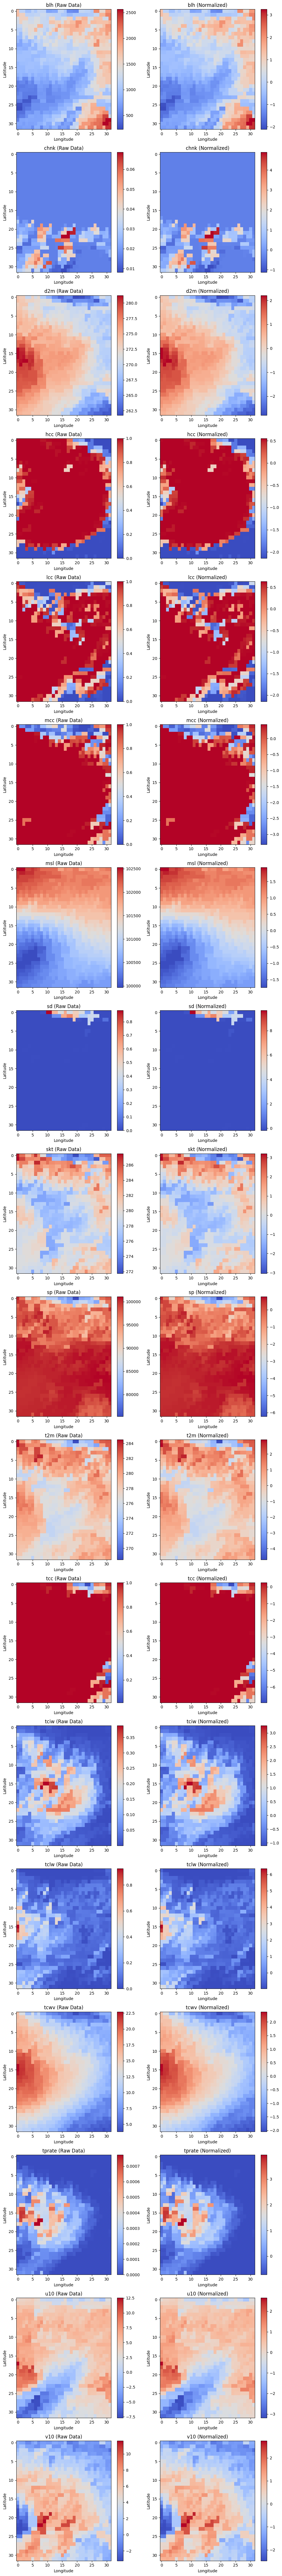

In [63]:
import matplotlib.pyplot as plt

# Select a specific time index (e.g., first time step)
time_idx = 10

# Create subplots (2 columns: before & after normalization)
fig, axes = plt.subplots(len(variables), 2, figsize=(10, 5 * len(variables)))

for i, v in enumerate(variables):
    # Extract data for the variable at the given time step
    tmp_data = train_lr[v].isel(time=time_idx)

    # Compute mean & std for normalization
    mean = tmp_data.mean().values
    std = tmp_data.std().values
    normalized = (tmp_data.values - mean) / std

    # Plot original data
    ax1 = axes[i, 0] if len(variables) > 1 else axes[0]
    im1 = ax1.imshow(tmp_data, cmap="coolwarm", aspect="auto")
    ax1.set_title(f"{v} (Raw Data)")
    ax1.set_xlabel("Longitude")
    ax1.set_ylabel("Latitude")
    fig.colorbar(im1, ax=ax1)

    # Plot normalized data
    ax2 = axes[i, 1] if len(variables) > 1 else axes[1]
    im2 = ax2.imshow(normalized, cmap="coolwarm", aspect="auto")
    ax2.set_title(f"{v} (Normalized)")
    ax2.set_xlabel("Longitude")
    ax2.set_ylabel("Latitude")
    fig.colorbar(im2, ax=ax2)

# Adjust layout for better readability
plt.tight_layout()
plt.show()

### 4. Create DataLoader

In [64]:
import torch
from torch.utils.data import Dataset, DataLoader

def z_score_normalization(tensor: torch.Tensor) -> torch.Tensor:
    """
    Perform Z-score normalization for each channel of the input tensor.

    Args:
        tensor (torch.Tensor): Input tensor of shape [C, H, W].

    Returns:
        torch.Tensor: Normalized tensor.
    """
    mean = tensor.mean(dim=[1, 2], keepdim=True)  # Mean along H and W for each channel
    std = tensor.std(dim=[1, 2], keepdim=True)    # Standard deviation along H and W for each channel

    # Prevent division by zero
    std = std + 1e-6

    return (tensor - mean) / std


class CreateDataset(Dataset):
    """
    PyTorch Dataset for handling low-resolution (LR) and high-resolution (HR)
    climate data for super-resolution tasks.

    Attributes:
        hr_data (xarray.Dataset): High-resolution dataset.
        lr_data (xarray.Dataset): Low-resolution dataset.
        hr_variables (list): List of HR variable names.
        lr_variables (list): List of LR variable names.
    """

    def __init__(self, lr_data, hr_data):
        """
        Initialize the dataset with low-resolution and high-resolution climate data.

        Args:
            lr_data (xarray.Dataset): Low-resolution dataset.
            hr_data (xarray.Dataset): High-resolution dataset.
        """

        self.hr_data = hr_data
        self.lr_data = lr_data
        self.lr_variables = list(self.lr_data.data_vars)
        self.hr_variables = list(self.hr_data.data_vars)

    def __len__(self) -> int:
        """
        Get the total number of time steps in the dataset.

        Returns:
            int: The number of time steps.
        """
        return self.hr_data.dims["time"]

    def __getitem__(self, idx: int) -> tuple:
        """
        Retrieve a single sample of low-resolution and high-resolution data.

        Args:
            idx (int): Index of the sample to return.

        Returns:
            tuple: A tuple containing:
                - lr_norm (torch.Tensor): Normalized low-resolution tensor (C, H, W).
                - hr_norm (torch.Tensor): Normalized high-resolution tensor (C, H, W).
        """
        # Extract HR and LR data at the given time index
        hr_sample = self.hr_data.isel(time=idx).to_array().values  # (C, H, W)
        lr_sample = self.lr_data.isel(time=idx).to_array().values  # (C, H, W)

        # Convert to torch tensors
        hr_sample = torch.tensor(hr_sample, dtype=torch.float32)
        lr_sample = torch.tensor(lr_sample, dtype=torch.float32)

        # Apply Z-score normalization
        hr_norm = z_score_normalization(hr_sample)
        lr_norm = z_score_normalization(lr_sample)

        return lr_norm, hr_norm


In [65]:
train_dataset = CreateDataset(hr_data=hr, lr_data=lr)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=14)

In [66]:
for i, (image, target) in enumerate(train_loader):

    if i==0:

        inputs = image
        targets = target

        break

In [67]:
inputs.shape

torch.Size([32, 18, 32, 32])

In [68]:
targets.shape

torch.Size([32, 1, 256, 256])

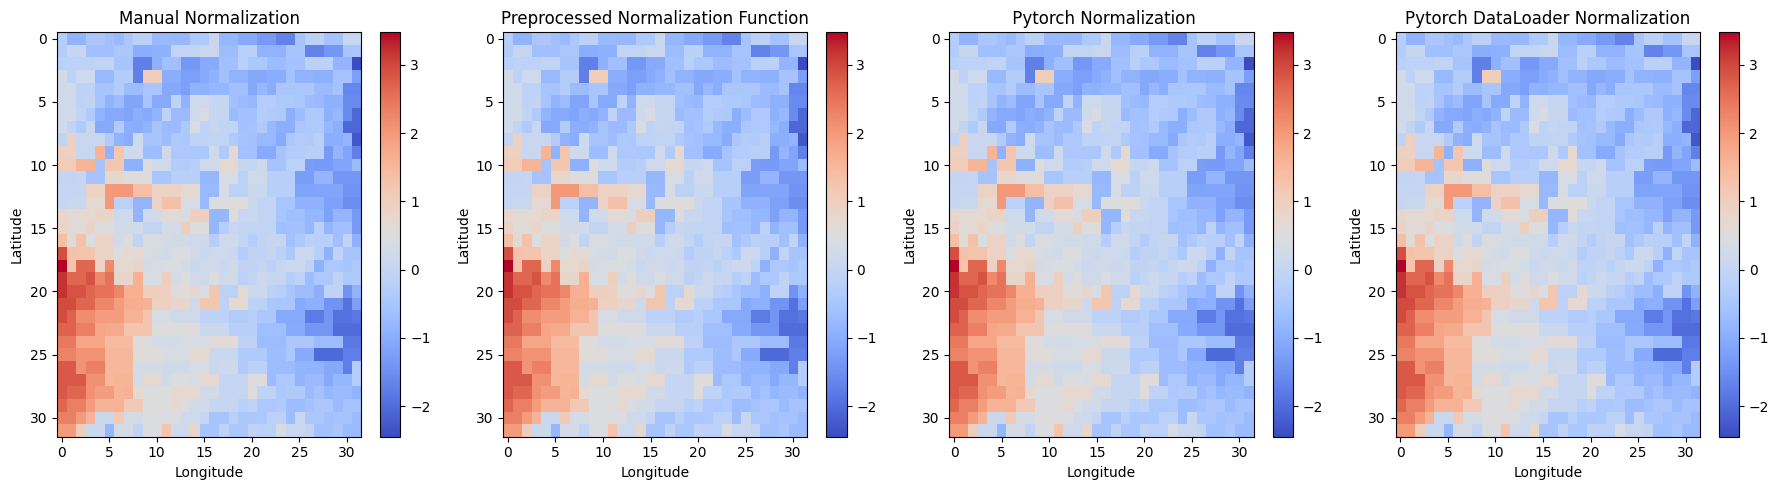

In [69]:
# Extract manually normalized data
time_idx = 10
tmp_data = lr["v10"].isel(time=time_idx)
mean = tmp_data.mean().values
std = tmp_data.std().values
manual_normalized = (tmp_data.values - mean) / std

# Auto-normalized data using your preprocessing function
normalized_xarray = normalize_xarray(dataset=lr, variables=variables)
auto_normalized = normalized_xarray["v10"].isel(time=time_idx).values

# Convert the data to tensor for Z-score normalization
lr_tensor = torch.tensor(lr["v10"].isel(time=time_idx).values).unsqueeze(0)

# Apply Z-score normalization using the z_score_normalization function
z_score_normalized = z_score_normalization(lr_tensor).squeeze().numpy()

# Create subplots (1 row, 3 columns)
fig, axes = plt.subplots(1, 4, figsize=(18, 5))

# Plot manually normalized data
im1 = axes[0].imshow(manual_normalized, cmap="coolwarm", aspect="auto")
axes[0].set_title("Manual Normalization")
axes[0].set_xlabel("Longitude")
axes[0].set_ylabel("Latitude")
fig.colorbar(im1, ax=axes[0])

# Plot preprocessed normalized data
im2 = axes[1].imshow(auto_normalized, cmap="coolwarm", aspect="auto")
axes[1].set_title("Preprocessed Normalization Function")
axes[1].set_xlabel("Longitude")
axes[1].set_ylabel("Latitude")
fig.colorbar(im1, ax=axes[1])

# Plot Z-score normalized data
im3 = axes[2].imshow(z_score_normalized, cmap="coolwarm", aspect="auto")
axes[2].set_title(" Pytorch Normalization")
axes[2].set_xlabel("Longitude")
axes[2].set_ylabel("Latitude")
fig.colorbar(im1, ax=axes[2])

# Plot Z-score normalized data
im3 = axes[3].imshow(np.array(inputs[time_idx,-1,:,:]), cmap="coolwarm", aspect="auto")
axes[3].set_title("Pytorch DataLoader Normalization")
axes[3].set_xlabel("Longitude")
axes[3].set_ylabel("Latitude")
fig.colorbar(im1, ax=axes[3])

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [70]:
print((np.array(inputs[time_idx,-1,:,:]) - z_score_normalized ).mean())
print((np.array(inputs[time_idx,-1,:,:]) - z_score_normalized ).std())
print((np.array(inputs[time_idx,-1,:,:]) - z_score_normalized ).max())
print((np.array(inputs[time_idx,-1,:,:]) - z_score_normalized ).min())

0.0
0.0
0.0
0.0


In [71]:
train_dataset = CreateDataset(lr_data=train_lr, hr_data=train_hr)
val_dataset = CreateDataset(lr_data=train_lr, hr_data=val_hr)
test_dataset = CreateDataset(lr_data=test_lr, hr_data=test_hr)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=14)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=14)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=14)

### 5. Initialize Model


In [72]:
import os
from torchmetrics import PeakSignalNoiseRatio, StructuralSimilarityIndexMeasure
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cf
import lightning as L
from utils.general import get_bbox_from_config


class TrainerSr(L.LightningModule):
    def __init__(self, config, model):
        super().__init__()

        self.bbox = get_bbox_from_config(config=config)
        self.lr = config['training']['learning_rate']
        self.model = model
        self.psnr = PeakSignalNoiseRatio()
        self.ssim = StructuralSimilarityIndexMeasure()
        # self.lr_mean = config["dataset"]["lr_mean"]
        # self.lr_std = config["dataset"]["hr_std"]
        # self.hr_mean = config["dataset"]["hr_mean"]
        # self.hr_std = config["dataset"]["lr_std"]
        self.cmap = config['visualization']['color_map']
        self.loss_function = config['training']['loss_function']
        self.opt = config['training']['optimizer']

    def forward(self, x):
        upscaled_img = self.model(x)
        return upscaled_img

    def training_step(self, batch, batch_idx):

        lr_img, hr_img = batch
        sr_img = self(lr_img)
        # loss = nn.functional.mse_loss(sr_img, hr_img)
        loss_function = getattr(nn.functional, self.loss_function)
        loss = loss_function(sr_img, hr_img)

        psnr_value = self.psnr(sr_img, hr_img)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_psnr', psnr_value, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        lr_img, hr_img = batch
        sr_img = self(lr_img)
        loss_function = getattr(nn.functional, self.loss_function)
        loss = loss_function(sr_img, hr_img)
        psnr_value = self.psnr(sr_img, hr_img)
        ssim_value = self.ssim(sr_img, hr_img)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_psnr', psnr_value, prog_bar=True)
        self.log('val_ssim', ssim_value, prog_bar=True)
        # Log images to TensorBoard every 1 steps
        # if batch_idx == 1:
        #     self.log_images(
        #         lr_img,
        #         hr_img,
        #         sr_img,
        #         self.current_epoch,
        #         batch_idx)
        return {
            'val_loss': loss,
            'val_psnr': psnr_value,
            'val_ssim': ssim_value}

    def test_step(self, batch):
        lr_img, hr_img = batch
        sr_img = self(lr_img)
        loss_function = getattr(nn.functional, self.loss_function)
        loss = loss_function(sr_img, hr_img)
        psnr_value = self.psnr(sr_img, hr_img)
        ssim_value = self.ssim(sr_img, hr_img)

        self.log('test_loss', loss, prog_bar=True)
        self.log('test_psnr', psnr_value, prog_bar=True)
        self.log('test_ssim', ssim_value, prog_bar=True)

        return {
            'test_loss': loss,
            'test_psnr': psnr_value,
            'test_ssim': ssim_value}

    def configure_optimizers(self):

        optimizer = getattr(torch.optim, self.opt)
        optimizer = optimizer(self.parameters(), lr=self.lr)
        return optimizer

    def log_images(self, lr_img, hr_img, sr_img, epoch, batch_idx):
        """
        Helper function to log input, target, and output images to TensorBoard, including cartopy plots
        """
        # Ensure images are in range [0, 1]
        lr_img = lr_img.cpu()
        hr_img = hr_img.cpu()
        sr_img = sr_img.cpu()

        lr_img = (lr_img * self.lr_std) + self.lr_mean
        hr_img = (hr_img * self.hr_std) + self.hr_mean

        # Convert lr_img, hr_img to numpy for cartopy visualization
        lr_img_np = lr_img.squeeze().numpy()[1]  # (lat, lon) format
        hr_img_np = hr_img.squeeze().numpy()[1]  # (lat, lon) format
        sr_img_np = sr_img.squeeze().numpy()[1]  # (lat, lon) format
        sr_img_np = (sr_img_np * self.hr_std) + self.hr_mean
        # Define color limits based on the range of values
        v_min = min(lr_img_np.min(), hr_img_np.min(), sr_img_np.min())
        v_max = max(lr_img_np.max(), hr_img_np.max(), sr_img_np.max())
        # Create a figure with three subplots for LR, HR, and SR images
        fig, ax = plt.subplots(
            1, 3, figsize=(
                18, 6), subplot_kw={
                'projection': ccrs.Mercator()})
        # Plot low-resolution data
        ax[0].coastlines()
        ax[0].add_feature(cf.BORDERS)
        ax[0].set_extent(self.bbox, crs=ccrs.PlateCarree())
        lr_plot = ax[0].imshow(
            lr_img_np,
            origin='upper',
            extent=self.bbox,
            transform=ccrs.PlateCarree(),
            cmap=self.cmap,
            vmin=v_min,
            vmax=v_max)
        ax[0].set_title("Low-Resolution")
        # Plot high-resolution data
        ax[1].coastlines()
        ax[1].add_feature(cf.BORDERS)
        ax[1].set_extent(self.bbox, crs=ccrs.PlateCarree())
        hr_plot = ax[1].imshow(
            hr_img_np,
            origin='upper',
            extent=self.bbox,
            transform=ccrs.PlateCarree(),
            cmap=self.cmap,
            vmin=v_min,
            vmax=v_max)
        ax[1].set_title("High-Resolution")
        # Plot super-resolved data
        ax[2].coastlines()
        ax[2].add_feature(cf.BORDERS)
        ax[2].set_extent(self.bbox, crs=ccrs.PlateCarree())
        sr_plot = ax[2].imshow(
            sr_img_np,
            origin='upper',
            extent=self.bbox,
            transform=ccrs.PlateCarree(),
            cmap=self.cmap,
            vmin=v_min,
            vmax=v_max)
        ax[2].set_title("Super-Resolution Prediction")
        # Add a colorbar outside the last plot (super-resolution)
        cbar = fig.colorbar(sr_plot, ax=ax, location='right')
        cbar.set_label("Temperature (C)")  # Add units to the colorbar
        # Get the current logging directory (e.g., lightning_logs/version_0)
        log_dir = self.logger.log_dir
        save_dir = os.path.join(log_dir, 'val_prediction')
        # Create the directory if it doesn't exist
        os.makedirs(save_dir, exist_ok=True)
        # Save the figure to a PNG file
        plt.savefig(
            f"{save_dir}/batch_{
                str(batch_idx)}_epoch_{
                str(epoch)}.png",
            format='png',
            bbox_inches='tight')
        plt.close(fig)

In [79]:
# -----------------------------------------------------------------------------------
# SwinIR: Image Restoration Using Swin Transformer, https://arxiv.org/abs/2108.10257
# Originally Written by Ze Liu, Modified by Jingyun Liang.
# -----------------------------------------------------------------------------------

import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
from timm.models.layers import DropPath, to_2tuple, trunc_normal_


class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


class ConvolutionalBlock(nn.Module):
    """
    A convolutional block, comprising convolutional, BN, activation layers.
    """

    def __init__(self, in_channels, out_channels, kernel_size, stride=1, batch_norm=False, activation=None):
        """
        :param in_channels: number of input channels
        :param out_channels: number of output channe;s
        :param kernel_size: kernel size
        :param stride: stride
        :param batch_norm: include a BN layer?
        :param activation: Type of activation; None if none
        """
        super(ConvolutionalBlock, self).__init__()

        if activation is not None:
            activation = activation.lower()
            assert activation in {'prelu', 'leakyrelu', 'tanh','relu'}

        # A container that will hold the layers in this convolutional block
        layers = list()

        # A convolutional layer
        layers.append(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride,
                      padding=kernel_size // 2))

        # A batch normalization (BN) layer, if wanted
        if batch_norm is True:
            layers.append(nn.BatchNorm2d(num_features=out_channels))

        # An activation layer, if wanted
        if activation == 'prelu':
            layers.append(nn.PReLU())
        elif activation == 'leakyrelu':
            layers.append(nn.LeakyReLU(0.2))
        elif activation == 'tanh':
            layers.append(nn.Tanh())
        elif activation == 'relu':
            layers.append(nn.ReLU())

        # Put together the convolutional block as a sequence of the layers in this container
        self.conv_block = nn.Sequential(*layers)

    def forward(self, input):
        """
        Forward propagation.

        :param input: input images, a tensor of size (N, in_channels, w, h)
        :return: output images, a tensor of size (N, out_channels, w, h)
        """
        output = self.conv_block(input)  # (N, out_channels, w, h)

        return output

def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size

    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image

    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.

    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)

        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'

    def flops(self, N):
        # calculate flops for 1 window with token length of N
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops


class SwinTransformerBlock(nn.Module):
    r""" Swin Transformer Block.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if self.shift_size > 0:
            attn_mask = self.calculate_mask(self.input_resolution)
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def calculate_mask(self, x_size):
        # calculate attention mask for SW-MSA
        H, W = x_size
        img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
        h_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        w_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        cnt = 0
        for h in h_slices:
            for w in w_slices:
                img_mask[:, h, w, :] = cnt
                cnt += 1

        mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
        mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

        return attn_mask

    def forward(self, x, x_size):
        H, W = x_size
        B, L, C = x.shape
        # assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA (to be compatible for testing on images whose shapes are the multiple of window size
        if self.input_resolution == x_size:
            attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C
        else:
            attn_windows = self.attn(x_windows, mask=self.calculate_mask(x_size).to(x.device))

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops


class PatchMerging(nn.Module):
    r""" Patch Merging Layer.

    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops


class BasicLayer(nn.Module):
    """ A basic Swin Transformer layer for one stage.

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x, x_size):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x, x_size)
            else:
                x = blk(x, x_size)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops


class RSTB(nn.Module):
    """Residual Swin Transformer Block (RSTB).

    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
        img_size: Input image size.
        patch_size: Patch size.
        resi_connection: The convolutional block before residual connection.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False,
                 img_size=224, patch_size=4, resi_connection='1conv'):
        super(RSTB, self).__init__()

        self.dim = dim
        self.input_resolution = input_resolution

        self.residual_group = BasicLayer(dim=dim,
                                         input_resolution=input_resolution,
                                         depth=depth,
                                         num_heads=num_heads,
                                         window_size=window_size,
                                         mlp_ratio=mlp_ratio,
                                         qkv_bias=qkv_bias, qk_scale=qk_scale,
                                         drop=drop, attn_drop=attn_drop,
                                         drop_path=drop_path,
                                         norm_layer=norm_layer,
                                         downsample=downsample,
                                         use_checkpoint=use_checkpoint)

        if resi_connection == '1conv':
            self.conv = nn.Conv2d(dim, dim, 3, 1, 1)
        elif resi_connection == '3conv':
            # to save parameters and memory
            self.conv = nn.Sequential(nn.Conv2d(dim, dim // 4, 3, 1, 1), nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                      nn.Conv2d(dim // 4, dim // 4, 1, 1, 0),
                                      nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                      nn.Conv2d(dim // 4, dim, 3, 1, 1))

        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=0, embed_dim=dim,
            norm_layer=None)

        self.patch_unembed = PatchUnEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=0, embed_dim=dim,
            norm_layer=None)

    def forward(self, x, x_size):
        return self.patch_embed(self.conv(self.patch_unembed(self.residual_group(x, x_size), x_size))) + x

    def flops(self):
        flops = 0
        flops += self.residual_group.flops()
        H, W = self.input_resolution
        flops += H * W * self.dim * self.dim * 9
        flops += self.patch_embed.flops()
        flops += self.patch_unembed.flops()

        return flops


class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding

    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        x = x.flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        flops = 0
        H, W = self.img_size
        if self.norm is not None:
            flops += H * W * self.embed_dim
        return flops


class PatchUnEmbed(nn.Module):
    r""" Image to Patch Unembedding

    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

    def forward(self, x, x_size):
        B, HW, C = x.shape
        x = x.transpose(1, 2).view(B, self.embed_dim, x_size[0], x_size[1])  # B Ph*Pw C
        return x

    def flops(self):
        flops = 0
        return flops


class Upsample(nn.Sequential):
    """Upsample module.

    Args:
        scale (int): Scale factor. Supported scales: 2^n and 3.
        num_feat (int): Channel number of intermediate features.
    """

    def __init__(self, scale, num_feat):
        m = []
        if (scale & (scale - 1)) == 0:  # scale = 2^n
            for _ in range(int(math.log(scale, 2))):
                m.append(nn.Conv2d(num_feat, 4 * num_feat, 3, 1, 1))
                m.append(nn.PixelShuffle(2))
        elif scale == 3:
            m.append(nn.Conv2d(num_feat, 9 * num_feat, 3, 1, 1))
            m.append(nn.PixelShuffle(3))
        else:
            raise ValueError(f'scale {scale} is not supported. ' 'Supported scales: 2^n and 3.')
        super(Upsample, self).__init__(*m)


class UpsampleOneStep(nn.Sequential):
    """UpsampleOneStep module (the difference with Upsample is that it always only has 1conv + 1pixelshuffle)
       Used in lightweight SR to save parameters.

    Args:
        scale (int): Scale factor. Supported scales: 2^n and 3.
        num_feat (int): Channel number of intermediate features.

    """

    def __init__(self, scale, num_feat, num_out_ch, input_resolution=None):
        self.num_feat = num_feat
        self.input_resolution = input_resolution
        m = []
        m.append(nn.Conv2d(num_feat, (scale ** 2) * num_out_ch, 3, 1, 1))
        m.append(nn.PixelShuffle(scale))
        super(UpsampleOneStep, self).__init__(*m)

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.num_feat * 3 * 9
        return flops


class SwinIR(nn.Module):
    r""" SwinIR
        A PyTorch impl of : `SwinIR: Image Restoration Using Swin Transformer`, based on Swin Transformer.

    Args:
        img_size (int | tuple(int)): Input image size. Default 64
        patch_size (int | tuple(int)): Patch size. Default: 1
        in_chans (int): Number of input image channels. Default: 3
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
        upscale: Upscale factor. 2/3/4/8 for image SR, 1 for denoising and compress artifact reduction
        img_range: Image range. 1. or 255.
        upsampler: The reconstruction reconstruction module. 'pixelshuffle'/'pixelshuffledirect'/'nearest+conv'/None
        resi_connection: The convolutional block before residual connection. '1conv'/'3conv'
    """

    def __init__(self, img_size=64, patch_size=1, in_chans=3,
                 embed_dim=96, depths=[6, 6, 6, 6], num_heads=[6, 6, 6, 6],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, upscale=2, img_range=1., upsampler='', resi_connection='1conv',
                 **kwargs):
        super(SwinIR, self).__init__()
        num_in_ch = in_chans
        num_out_ch = in_chans
        num_feat = 64
        self.img_range = img_range
        if in_chans == 3:
            rgb_mean = (0.4488, 0.4371, 0.4040)
            self.mean = torch.Tensor(rgb_mean).view(1, 3, 1, 1)
        else:
            self.mean = torch.zeros(1, 1, 1, 1)
        self.upscale = upscale
        self.upsampler = upsampler
        self.window_size = window_size

        #####################################################################################################
        ################################### 1, shallow feature extraction ###################################
        self.conv_first = nn.Conv2d(num_in_ch, embed_dim, 3, 1, 1)

        #####################################################################################################
        ################################### 2, deep feature extraction ######################################
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = embed_dim
        self.mlp_ratio = mlp_ratio

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=embed_dim, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # merge non-overlapping patches into image
        self.patch_unembed = PatchUnEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=embed_dim, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build Residual Swin Transformer blocks (RSTB)
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = RSTB(dim=embed_dim,
                         input_resolution=(patches_resolution[0],
                                           patches_resolution[1]),
                         depth=depths[i_layer],
                         num_heads=num_heads[i_layer],
                         window_size=window_size,
                         mlp_ratio=self.mlp_ratio,
                         qkv_bias=qkv_bias, qk_scale=qk_scale,
                         drop=drop_rate, attn_drop=attn_drop_rate,
                         drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],  # no impact on SR results
                         norm_layer=norm_layer,
                         downsample=None,
                         use_checkpoint=use_checkpoint,
                         img_size=img_size,
                         patch_size=patch_size,
                         resi_connection=resi_connection

                         )
            self.layers.append(layer)
        self.norm = norm_layer(self.num_features)

        # build the last conv layer in deep feature extraction
        if resi_connection == '1conv':
            self.conv_after_body = nn.Conv2d(embed_dim, embed_dim, 3, 1, 1)
        elif resi_connection == '3conv':
            # to save parameters and memory
            self.conv_after_body = nn.Sequential(nn.Conv2d(embed_dim, embed_dim // 4, 3, 1, 1),
                                                 nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                                 nn.Conv2d(embed_dim // 4, embed_dim // 4, 1, 1, 0),
                                                 nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                                 nn.Conv2d(embed_dim // 4, embed_dim, 3, 1, 1))

        #####################################################################################################
        ################################ 3, high quality image reconstruction ################################
        if self.upsampler == 'pixelshuffle':
            # for classical SR
            self.conv_before_upsample = nn.Sequential(nn.Conv2d(embed_dim, num_feat, 3, 1, 1),
                                                      nn.LeakyReLU(inplace=True))
            self.upsample = Upsample(upscale, num_feat)
            self.conv_last = nn.Conv2d(num_feat, num_out_ch, 3, 1, 1)
        elif self.upsampler == 'pixelshuffledirect':
            # for lightweight SR (to save parameters)
            self.upsample = UpsampleOneStep(upscale, embed_dim, num_out_ch,
                                            (patches_resolution[0], patches_resolution[1]))
            self.last_conv = ConvolutionalBlock(in_channels=18, out_channels=1, kernel_size=9,
                                              batch_norm=True, activation='ReLu')
        elif self.upsampler == 'nearest+conv':
            # for real-world SR (less artifacts)
            self.conv_before_upsample = nn.Sequential(nn.Conv2d(embed_dim, num_feat, 3, 1, 1),
                                                      nn.LeakyReLU(inplace=True))
            self.conv_up1 = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
            if self.upscale == 4:
                self.conv_up2 = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
            self.conv_hr = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
            self.conv_last = nn.Conv2d(num_feat, num_out_ch, 3, 1, 1)
            self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        else:
            # for image denoising and JPEG compression artifact reduction
            self.conv_last = nn.Conv2d(embed_dim, num_out_ch, 3, 1, 1)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def check_image_size(self, x):
        _, _, h, w = x.size()
        mod_pad_h = (self.window_size - h % self.window_size) % self.window_size
        mod_pad_w = (self.window_size - w % self.window_size) % self.window_size
        x = F.pad(x, (0, mod_pad_w, 0, mod_pad_h), 'reflect')
        return x

    def forward_features(self, x):
        x_size = (x.shape[2], x.shape[3])
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x, x_size)

        x = self.norm(x)  # B L C
        x = self.patch_unembed(x, x_size)

        return x

    def forward(self, x):
        H, W = x.shape[2:]
        x = self.check_image_size(x)

        self.mean = self.mean.type_as(x)
        x = (x - self.mean) * self.img_range

        if self.upsampler == 'pixelshuffle':
            # for classical SR
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            x = self.conv_before_upsample(x)
            x = self.conv_last(self.upsample(x))
        elif self.upsampler == 'pixelshuffledirect':
            # for lightweight SR
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            x = self.upsample(x)
            x = self.last_conv(x)


        elif self.upsampler == 'nearest+conv':
            # for real-world SR
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            x = self.conv_before_upsample(x)
            x = self.lrelu(self.conv_up1(torch.nn.functional.interpolate(x, scale_factor=2, mode='nearest')))
            if self.upscale == 4:
                x = self.lrelu(self.conv_up2(torch.nn.functional.interpolate(x, scale_factor=2, mode='nearest')))
            x = self.conv_last(self.lrelu(self.conv_hr(x)))
        else:
            # for image denoising and JPEG compression artifact reduction
            x_first = self.conv_first(x)
            res = self.conv_after_body(self.forward_features(x_first)) + x_first
            x = x + self.conv_last(res)

        x = x / self.img_range + self.mean

        return x[:, :, :H*self.upscale, :W*self.upscale]

    def flops(self):
        flops = 0
        H, W = self.patches_resolution
        flops += H * W * 3 * self.embed_dim * 9
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        flops += H * W * 3 * self.embed_dim * self.embed_dim
        flops += self.upsample.flops()
        return flops



upscale = 8
window_size = 8

sr_model = SwinIR(in_chans=18, upscale=upscale,
                window_size=window_size, img_range=1., depths=[6, 6, 6, 6],
                embed_dim=60, num_heads=[6, 6, 6, 6], mlp_ratio=2, upsampler='pixelshuffledirect')

In [80]:
# # Initialize SRResNet model based on config
# sr_model = getattr(models, config["model"]["architecture"])
# sr_model = sr_model(
#     in_channels = len(variables),
#     large_kernel_size=config["model"]["large_kernel_size"],
#     small_kernel_size=config["model"]["small_kernel_size"],
#     n_channels=config["model"]["n_channels"],
#     n_blocks=config["model"]["n_blocks"],
#     scaling_factor=config["model"]["scaling_factor"]
# )

# Wrap model in TrainerSr class
model = TrainerSr(config=config, model=sr_model)

In [81]:
x = torch.randn((1, 18, 32, 32))
x = sr_model(x)
print(x.shape)

torch.Size([1, 1, 256, 256])


### 6. Set Up Checkpointing and Trainer


In [82]:
# Define checkpoint callback
checkpoint_val_ssim = ModelCheckpoint(
    monitor=config['checkpoint']['monitor'], filename="best-val-ssim-{epoch:02d}-{val_ssim:.2f}",
    save_top_k=1, mode=config['checkpoint']['mode']
)

# Set up the PyTorch Lightning Trainer
trainer = L.Trainer(
    devices=config["training"]["devices"],
    max_epochs=config["training"]["epochs"],
    accelerator=config["training"]["accelerator"],
    deterministic=config["training"]["deterministic"],
    callbacks=[checkpoint_val_ssim],
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


### 7. Train the Model


In [ ]:
# Train the model
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                              | Params | Mode 
--------------------------------------------------------------------
0 | model | SwinIR                            | 1.5 M  | train
1 | psnr  | _PeakSignalNoiseRatio             | 0      | train
2 | ssim  | _StructuralSimilarityIndexMeasure | 0      | train
--------------------------------------------------------------------
1.5 M     Trainable params
0         Non-trainable params
1.5 M     Total params
6.146     Total estimated model params size (MB)
403       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

### 8. Evaluate and Test the Model


In [ ]:
# Load best model checkpoint
best_model_path = checkpoint_val_ssim.best_model_path
checkpoint = torch.load(best_model_path)
model.load_state_dict(checkpoint["state_dict"])

# Test the model
trainer.test(model, test_loader)

### 9. Visualize Results and Save Model


In [ ]:
# Generate visualizations and create GIF
create_gif_from_images(trainer=trainer)

# Save best model as .pt file
best_model_path = save_best_model_as_pt(checkpoint_val_ssim, sr_model)

# Save config to log directory
save_config_to_log_dir(log_dir_path=trainer.log_dir, config=config)

### 10. Inference

In [ ]:
from inference import SuperResolutionInference
sr_model = getattr(models, config["model"]["architecture"])
sr_model = sr_model(
    large_kernel_size=config["model"]["large_kernel_size"],
    small_kernel_size=config["model"]["small_kernel_size"],
    n_channels=config["model"]["n_channels"],
    n_blocks=config["model"]["n_blocks"],
    scaling_factor=config["model"]["scaling_factor"]
)
# Initialize the inference class
sr = SuperResolutionInference(model_path=best_model_path, model_class=sr_model)

# Load and preprocess a single LR image
lr_image = lr.sel(time="2024-10-15T12:00:00")
preprocessed_image = sr.preprocess(lr_image, lr_mean=lr_mean, lr_std=lr_std)

# Perform inference
sr_result = sr.inference(preprocessed_image)

# Post-process the SR result
sr_result = sr.postprocessing(sr_result, hr_mean, hr_std)
# Visualize the LR and SR images
fig = sr.visualize(lr_image=lr_image, sr_image=sr_result, lr_time=lr_image.time.values)